<a href="https://colab.research.google.com/github/daviddralle/cannabit/blob/main/cannabit_gq_phil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
import pandas as pd
import seaborn as sns
from shapely.geometry import Polygon
from scipy.optimize import curve_fit
import geopandas as gp
import glob
import matplotlib
import pickle
import urllib3
import datetime
import time
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format='retina'

In [ ]:
import requests
def download_file(url):
  fn = url.split('/')[-1]
  r = requests.get(url, allow_redirects=True)
  open(fn, 'wb').write(r.content)

download_file('https://raw.githubusercontent.com/daviddralle/daviddralle.github.io/master/lith.csv')
download_file('https://raw.githubusercontent.com/daviddralle/daviddralle.github.io/master/teaching_data/elder_discharge.csv')
# download_file('https://raw.githubusercontent.com/daviddralle/daviddralle.github.io/master/20220311_modeled_use_flow_landscape_coverage.csv')
download_file('https://raw.githubusercontent.com/daviddralle/daviddralle.github.io/master/level4e.csv')

import pandas as pd
df = pd.read_csv('./level4e.csv',index_col=0,parse_dates=True)
df = df[['dryRunoff_mmDay^-1']]
df.columns = ['runoff']
df.to_csv('./dry_discharge.csv')

!mkdir cannabit_data
!cp /content/level4e.csv /content/cannabit_data
!cp /content/dry_discharge.csv /content/cannabit_data
!cp /content/20240802_modeled_use_flow_landscape_coverage.csv /content/cannabit_data

<ipython-input-2-b2b3dc567f0d>:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('./level4e.csv',index_col=0,parse_dates=True)


mkdir: cannot create directory ‘cannabit_data’: File exists


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def getFlow(site,start,stop):
    url = 'https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=' + site + '&referred_module=sw&period=&begin_date='+start+'&end_date='+stop
    df = pd.read_csv(url, header=31, delim_whitespace=True)
    df.columns = ['usgs', 'site', 'datetime', 'q', 'a']
    df.index = pd.to_datetime(df.datetime)
    basin = gp.read_file('https://labs.waterdata.usgs.gov/api/nldi/linked-data/nwissite/USGS-%s/basin?f=json'%site)
    try:
      geoms = [item for item in list(basin.geometry[0])]
      idx = np.argmax([item.area for item in geoms])
      basin.geometry = [geoms[idx]]
      print('Found multipolygon - fixing')
    except:
      basin.geometry = basin.geometry
    area_mm2 = basin.to_crs('epsg:26910').geometry[0].area*1000**2
    df = 2.44657555e12*df[['q']]/area_mm2
    df.q = df.q.astype(float, errors='ignore')
    df.columns = [site]
    return df, basin

# Sensitivity function [see Kirchner, 2009] doi:10.1029/2008WR006912
def gQ(q,p):
    if np.size(np.array(q)) == 1: return np.exp(np.sum([p[i]*np.log(q)**(len(p)-i-1) for i in range(len(p))]))
    return [np.exp(np.sum([p[i]*np.log(qq)**(len(p)-i-1) for i in range(len(p))])) for qq in np.array(q)]

# Bin dq/dt data
def KirchnerBinning(df, min_per_bin = 10, loud=False, binsizefrac=0.01):
    df = df.sort_values('q',ascending=False)
    logQ = np.array(np.log(df.q))
    logRange = np.max(logQ) - np.min(logQ)
    minBinSize = logRange*binsizefrac
    binBoundaries = [0]
    for i in range(1,len(df)):
        if abs(logQ[i] - logQ[binBoundaries[-1]]) < minBinSize:
            if loud: print('Bin too small')
            continue

        if abs(i-binBoundaries[-1]) < min_per_bin:
            if loud: print('Not enough data points')
            continue

        curr = df.dq[binBoundaries[-1]:i]
        if np.std(-curr)/np.sqrt(abs(i-binBoundaries[-1])) > np.mean(-curr)/2:
            if loud: print('Bin too heterogeneous')
            continue

        binBoundaries.append(i)
    return binBoundaries

In [ ]:
gageNumsToNames = {
                   '11475560':'Elder Creek',
                   '00000000':'Dry Creek',
                    }

gagelist = ['11475560']#11475560']
startyear = '1950'
endyear = '2019'
startdate = startyear + '-01-01'
enddate = endyear + '-12-31'
basins = []
dfs = []
for gage in gagelist:
  df, basin = getFlow(gage,startdate, enddate)
  dfs.append(df)
  basins.append(basin.geometry[0])

# dataframe of flows
flow = pd.concat(dfs,axis=1)
dry = pd.read_csv('./dry_discharge.csv',index_col=0,parse_dates=True)
dry = dry.resample('D').mean()
dry.columns = ['00000000']
gagelist.append('00000000')
flow = pd.concat([flow,dry],axis=1)
flow = flow.loc[np.isfinite(flow['00000000'])]
flow = flow.loc[startdate:enddate]

11475560
00000000


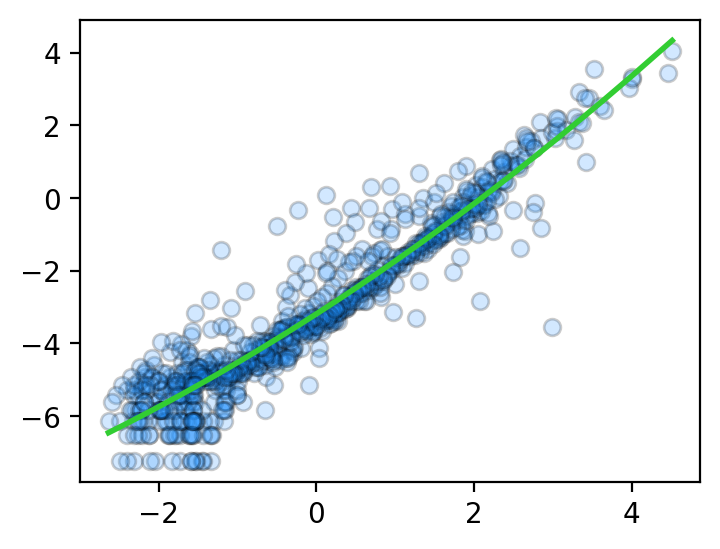

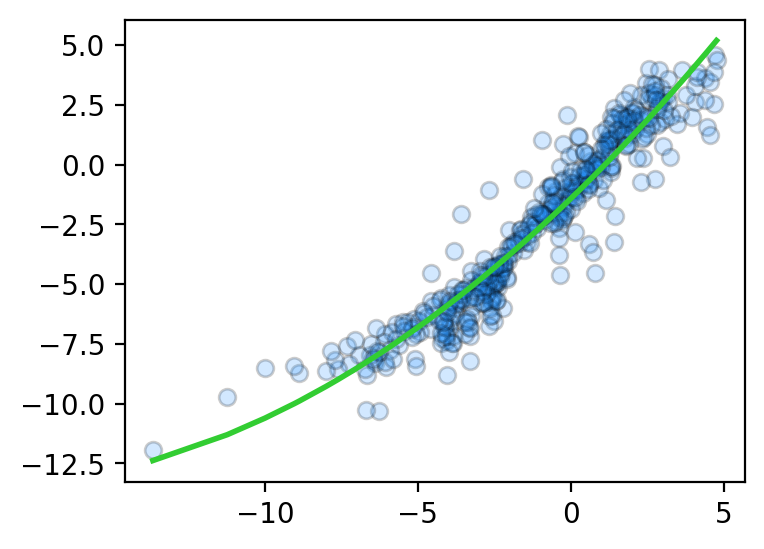

In [ ]:
ps = {}
ecdfs = {}
whichmonths = [4,5]
for gage in flow.columns:

  ecdf = ECDF(flow.loc[flow.index.month.isin(whichmonths)][gage].values)
  ecdfs[gage] = ecdf

  print(gage)
  tempdf = flow[[gage]]
  tempdf['year'] = tempdf.index.year
  tempdf['runoff'] = flow[gage]
  QS = []
  DQS = []
  for g in tempdf.groupby('year'):
    temp = g[1]
    date_q0 = temp.index.values[temp.runoff.argmax()]
    date_end = temp.index.values[-1]
    q0 = temp.runoff.max()
    qs = temp.runoff.loc[date_q0:].values
    dqs = np.gradient(qs)
    idx = (dqs<0)&(qs>0)
    qs = qs[idx]
    dqs = dqs[idx]
    QS = QS + list(qs)
    DQS = DQS + list(dqs)
  QS = np.array(QS)
  DQS = np.array(DQS)
  # df_kirchner = pd.DataFrame({'q':QS, 'dq':DQS})
  # df_kirchner = df_kirchner.sort_values('q',ascending=False)
  # binBoundaries = KirchnerBinning(df_kirchner, min_per_bin=10)
  # qs = [np.mean(df_kirchner.q[binBoundaries[i]:binBoundaries[i+1]]) for i in range(len(binBoundaries)-1)]
  # dqs =   np.array([np.mean(df_kirchner.dq[binBoundaries[i]:binBoundaries[i+1]]) for i in range(len(binBoundaries)-1)])
  # QS = np.array(qs)
  # DQS = np.array(dqs)
  # sigmas = np.array([np.std(np.log(-df_kirchner.dq[binBoundaries[i]:binBoundaries[i+1]].loc[df_kirchner.dq[binBoundaries[i]:binBoundaries[i+1]]<0]))/np.sqrt(binBoundaries[i+1]-binBoundaries[i]) for i in range(len(binBoundaries)-1)]) + 1e-12
  p = np.polyfit(x=np.log(QS), y=np.log(-DQS), deg=2)
  f,ax = plt.subplots(figsize=(4,3))
  x = np.log(QS)
  ax.scatter(np.log(QS),np.log(-DQS),ec='k',c='dodgerblue',alpha=0.2)
  x = np.sort(x)
  ax.plot(x, p[2] + p[1]*x + p[0]*x**2,lw=2,c='limegreen')
  p[1] = p[1] - 1
  ps[gage] = p

# Solve for natural and impaired recessions for various initial conditions and irrigation rates

In [ ]:
url = 'https://raw.githubusercontent.com/daviddralle/daviddralle.github.io/master/phil_data_cannabis.csv'
path = '/content/drive/MyDrive/research/cannaphil/20240802_modeled_use_flow_landscape_coverage.csv'
phil = pd.read_csv(path,index_col=0)
cols = phil.columns
cols = [col.replace('monhtyly','monthly') for col in cols]
cols = [col.replace('quantile','farm_use_percentile') for col in cols]

phil.columns = cols
phil.columns

Index(['month', 'year', 'creek', 'mean_daily_q_mm_day', 'modeled_use_mm_day',
       'farm_use_percentile', 'modeled_monthly_use_0.05cover',
       'modeled_monthly_use_0.1cover', 'modeled_monthly_use_0.5cover',
       'modeled_monthly_use_1cover', 'modeled_monthly_use_5cover'],
      dtype='object')

In [ ]:
from scipy.integrate import odeint
from scipy.interpolate import interp1d as interp1d
import scipy
from scipy.integrate import solve_ivp

months = phil.month.values
years = phil.year.values
dates = pd.to_datetime([str(years[i]) + '-' + str(months[i]) for i in range(len(months))])
phil['datetime'] = dates
use_percentiles = [0.25, 0.5 , 0.75, 0.9 , 0.95]
covers = [0.01, 0.05, 0.1,0.25, 0.5, 1.0,2.5, 5.0, 7.5, 10.0]
mapper = {'Dry Creek':'Dry Creek', 'Elder':'Elder Creek'}
phil['catchment'] = phil.creek.map(mapper)
Q0s = [0.1, 0.5, 1.0,2.0, 3.0, 5.0, 7.0, 9.0, 10.0]

dfs = []
for u in use_percentiles:
  for c in covers:
    for g in ['00000000','11475560']:
      for q0 in Q0s:
        for source in ['surface','groundwater']:
          p = ps[g]
          name = gageNumsToNames[g]
          tempdf = phil.loc[phil.farm_use_percentile==u].copy()
          tempdf = tempdf.loc[tempdf.catchment==name]
          tempdf['use'] = tempdf.modeled_use_mm_day * c/100.0
          tempdf = tempdf[['use','datetime']]
          tempdf = tempdf.set_index('datetime').sort_index()

          dates = pd.date_range('2016-05','2016-10',freq='D')
          tempdf = tempdf.reindex(dates).interpolate()


          tempdf = tempdf.loc[tempdf.index.month.isin([5,6,7,8,9])]
          tempdf = tempdf.loc[tempdf.index.year==tempdf.index.year.unique()[0]].copy()

          # integrate to get natural and impaired flows
          t = np.linspace(0,len(tempdf),len(tempdf))
          forcing = interp1d(t,tempdf.use.values,fill_value="extrapolate")

          # calculate average daily use
          # w = tempdf['use'].mean()


          def fun(time,q):
            return -gQ(q,p)*q
          sol = solve_ivp(fun, [0, t[-1]], [q0], rtol = 1e-5)
          sol_int = interp1d(sol.t,sol.y[0],fill_value=0,bounds_error=False)
          natQ = sol_int(t)

          def fun(time,q):
            return -gQ(q,p)*(q + forcing(time))

          if source=='groundwater':
            sol = solve_ivp(fun, [0, t[-1]], [q0], rtol = 1e-5)
            sol_int = interp1d(sol.t,sol.y[0],fill_value=0,bounds_error=False)
            impQ = sol_int(t)
          else:
            impQ = natQ - tempdf.use.values
            impQ[impQ<0] = 0

          tempdf['impQ'] = impQ
          tempdf['natQ'] = natQ
          tempdf['source'] = source
          tempdf['q0'] = q0
          tempdf['q0_percentile'] = ecdfs[g](q0)*100
          tempdf['c'] = c
          tempdf['g'] = g
          tempdf['u'] = u
          dfs.append(tempdf.copy())


In [ ]:
data.q0.unique()

array([ 0.1,  0.5,  1. ,  2. ,  3. ,  5. ,  7. ,  9. , 10. ])

In [ ]:
data = pd.concat(dfs,axis=0)
path = '/content/drive/MyDrive/research/cannaphil/cannaphil_sims.csv'
data.to_csv(path)

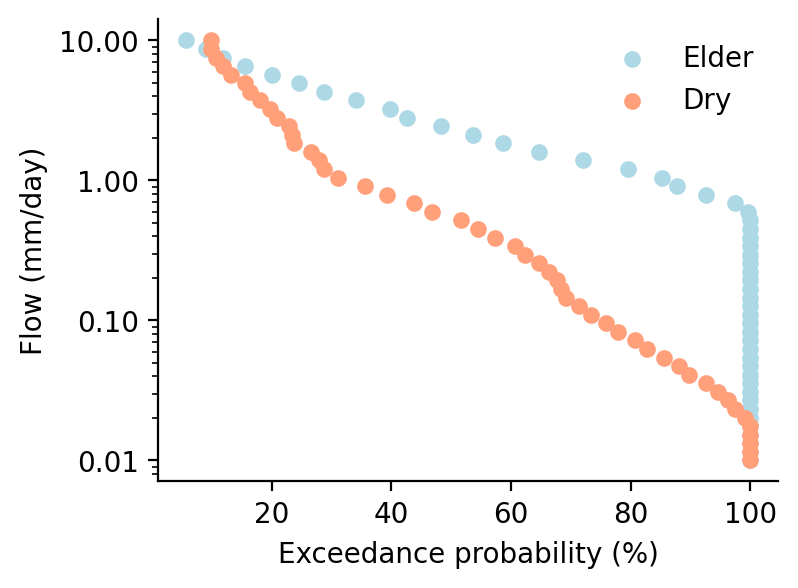

In [ ]:
f,ax = plt.subplots(figsize=(4,3))
ecdf = ecdfs['11475560']
x = np.logspace(-2,1)
y = ecdf(x)
ax.scatter(100*(1-y),x,label='Elder',s=25,ec='lightblue',fc='lightblue')
# plt.yscale('log')

ecdf = ecdfs['00000000']
x = np.logspace(-2,1)
y = ecdf(x)
ax.scatter(100*(1-y),x,label='Dry',s=25,ec='lightsalmon',fc='lightsalmon')
ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_ylabel('Flow (mm/day)')
ax.set_xlabel('Exceedance probability (%)')

sns.despine()
ax.legend(framealpha=0)
import matplotlib.ticker as mtick
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))


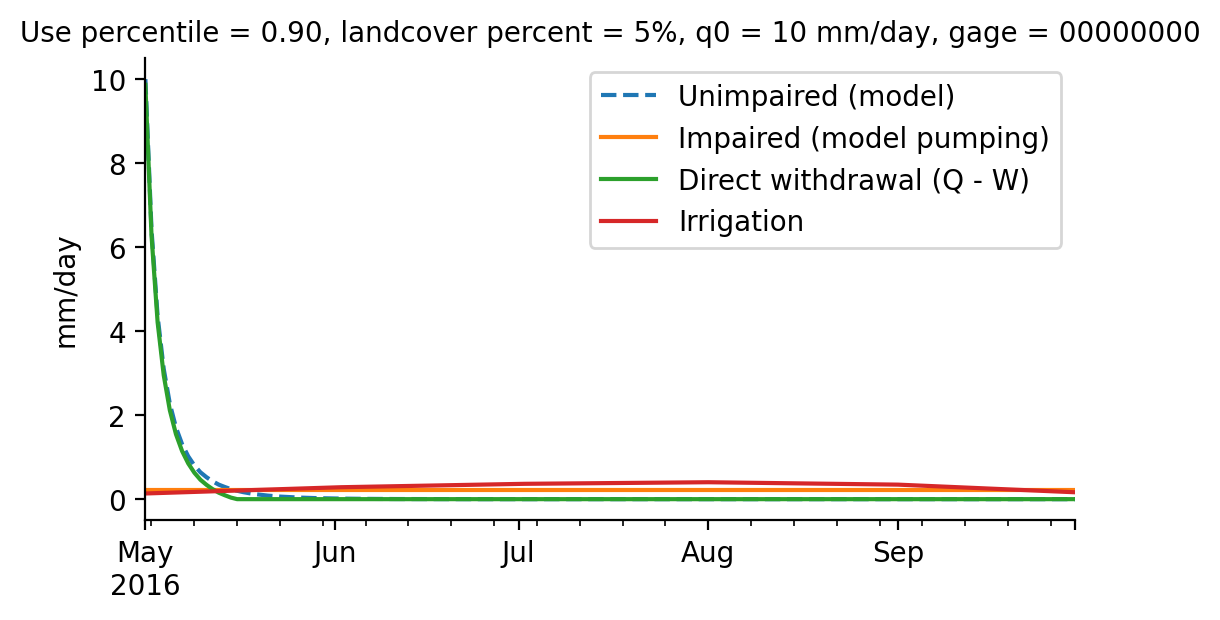

In [ ]:
perc,c = 0.9,5.0
q0 = 10.0
g = '00000000'

temp = data.loc[(data.u==perc)&(data.c==c)&
 (data.q0==q0)&(data.g==g)&(data.source=='groundwater')].copy()

irrigation = temp.use.copy()

f,ax = plt.subplots(figsize=(6,3))
# temp.runoff.plot(label = 'Q (mm/day)')
temp.natQ.plot(label='Unimpaired (model)',ls='--')
temp.impQ.plot(label='Impaired (model pumping)')

direct_withdrawal = temp.natQ - irrigation
direct_withdrawal[direct_withdrawal<0] = 0
direct_withdrawal.plot(label='Direct withdrawal (Q - W)')

irrigation.plot(ax=ax,label='Irrigation')
ax.legend()
ax.legend()
ax.set_title('Use percentile = %.2f, landcover percent = %.0f%%, q0 = %d mm/day, gage = %s'%(perc,c,q0,g),fontsize=10)
ax.set_ylabel('mm/day')
sns.despine()

In [ ]:
for u in use_percentiles:
  for c in covers:
    for g in ['00000000','11475560']:
      for q0 in Q0s:
        for source in ['surface','groundwater']:

In [ ]:
# prompt: group temp by 'c','u','q0','g','source', take the mean values of ws for each group, and reassign all values of ws in the original dataframe from that group to the mean value of ws

# Group data and calculate mean 'ws' for each group
grouped = data.groupby(['c', 'u', 'q0', 'g', 'source'])['impQ'].mean()

# Reassign 'ws' values in the original DataFrame
for group_index, mean_ws in grouped.items():
    c, u, q0, g, source = group_index
    data.loc[(data['c'] == c) & (data['u'] == u) & (data['q0'] == q0) & (data['g'] == g) & (data['source'] == source), 'impQ'] = mean_ws

In [ ]:
from re import TEMPLATE
g = '11475560'
temp = data.loc[data.g==g].copy()
tempdf.use * c/100.0

g = '11475560'
temp = data.loc[data.g==g].copy()
ws = tempdf.use * temp.c/100.0
temp['ws'] = ws.values


# Group data and calculate mean 'ws' for each group
grouped = temp.groupby(['c', 'u', 'q0', 'g', 'source'])['impQ'].mean()

# Reassign 'ws' values in the original DataFrame
for group_index, mean_ws in grouped.items():
    c, u, q0, g, source = group_index
    temp.loc[(temp['c'] == c) & (temp['u'] == u) & (temp['q0'] == q0) & (temp['g'] == g) & (temp['source'] == source), 'impQ'] = mean_ws

ws = temp.ws.values
q0s = temp.q0.values

WS,Q0S = np.meshgrid(ws,q0s)
shp = np.shape(WS)
WS = WS.flatten()
Q0S = Q0S.flatten()
Z_percloss = []



In [ ]:
# year,perc,c = 2019,0.5,2.5
# g = '00000000'
# temp = use_dfs[(perc,c,g,year)].copy()
# irrigation = use_dfs[(perc,c,g,year)]['pred_monthly_use%scover'%str(c)]
perc,c, source = 0.9,5.0, 'groundwater'
q0 = 10.0
g = '11475560'

temp = data.loc[(data.u==perc)&(data.c==c)&
 (data.q0==q0)&(data.g==g)&(data.source==source)].copy()

irrigation = temp.use.copy()

t = np.linspace(0,200,200)

p = ps[g]
rates = []
ws = np.linspace(0.01,0.5)
q0s = np.linspace(1,20)
WS,Q0S = np.meshgrid(ws,q0s)
shp = np.shape(WS)
WS = WS.flatten()
Q0S = Q0S.flatten()
Z_percloss = []
for i in range(len(Q0S)):

  natQ[0] = Q0S[i]
  natQ[np.isnan(natQ)] = 0



          name = gageNumsToNames[g]
          tempdf = phil.loc[phil.farm_use_percentile==u].copy()
          tempdf = tempdf.loc[tempdf.catchment==name]
          tempdf['use'] = tempdf.pred_use_mm_day * c/100.0
          tempdf = tempdf[['use','datetime']]
          tempdf = tempdf.set_index('datetime').sort_index()
          tempdf = tempdf.reindex(flow.index)
          tempdf = tempdf.interpolate()

          forcing = interp1d(range(len(tempdf)),tempdf.use.values,fill_value="extrapolate")

          # calculate average daily use
          tempdf = tempdf.loc[tempdf.index.month.isin([5,6,7,8,9])]
          tempdf = tempdf.loc[tempdf.index.year==tempdf.index.year.unique()[0]].copy()
          w = tempdf['use'].mean()

          # integrate to get natural and impaired flows
          t = np.linspace(0,len(tempdf),len(tempdf))

          def fun(time,q):
            return -gQ(q,p)*q
          sol = solve_ivp(fun, [0, t[-1]], [q0], rtol = 1e-5)
          sol_int = interp1d(sol.t,sol.y[0],fill_value=0,bounds_error=False)
          natQ = sol_int(t)

          def fun(time,q):
            return -gQ(q,p)*(q + forcing(time))

          if source=='groundwater':
            sol = solve_ivp(fun, [0, t[-1]], [q0], rtol = 1e-5)
            sol_int = interp1d(sol.t,sol.y[0],fill_value=0,bounds_error=False)
            impQ = sol_int(t)
          else:
            impQ = natQ - tempdf.use.values
            impQ[impQ<0] = 0


  sumnatQ = np.trapz(natQ,t)
  sumimpQ = np.trapz(impQ,t)
  frac = 1-sumimpQ/sumnatQ
  Z_percloss.append(frac*100)
  Z_drysoon.append(natdry - impdry)

IndentationError: unexpected indent (<ipython-input-9-051b8b2f437a>, line 32)

In [ ]:
plt.hist(Z_percloss)

NameError: name 'Z_percloss' is not defined

ValueError: cannot reshape array of size 0 into shape (42840,42840)

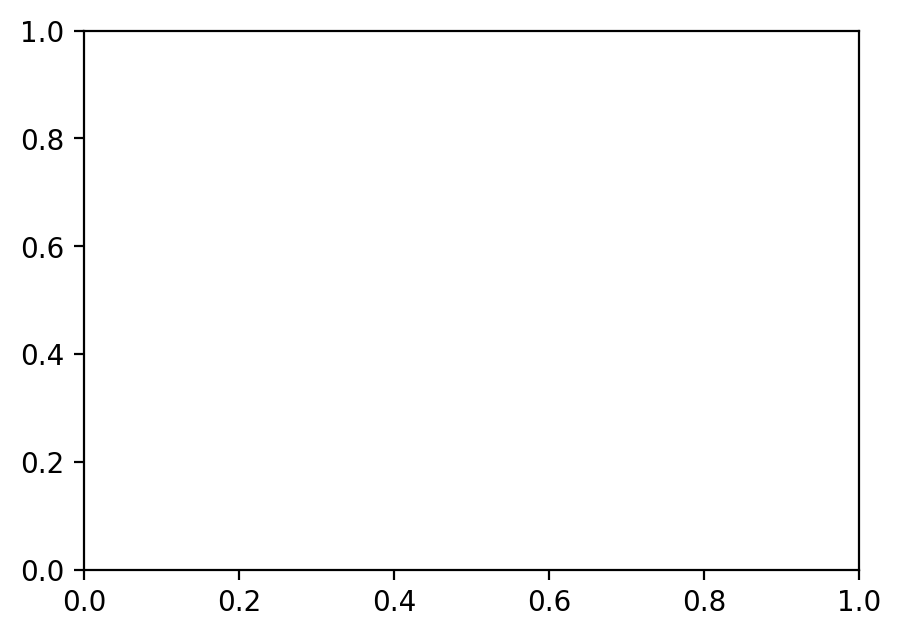

In [ ]:
f,ax = plt.subplots(figsize=(5,3.5))
z = np.reshape(Z_percloss,shp)
q0s = np.reshape(Q0S,shp)
ws = np.reshape(WS,shp)
m = ax.contourf(q0s,ws,z)
ax.set_ylabel('Effective avg pump rate (mm/day)\n' + r'($=\%coverage\cdot rate)$')
ax.set_xlabel('Initial flow value (mm/day)')
cb = f.colorbar(m)
cb.set_label('Percent loss of summer flow',fontsize=10)
f.tight_layout()

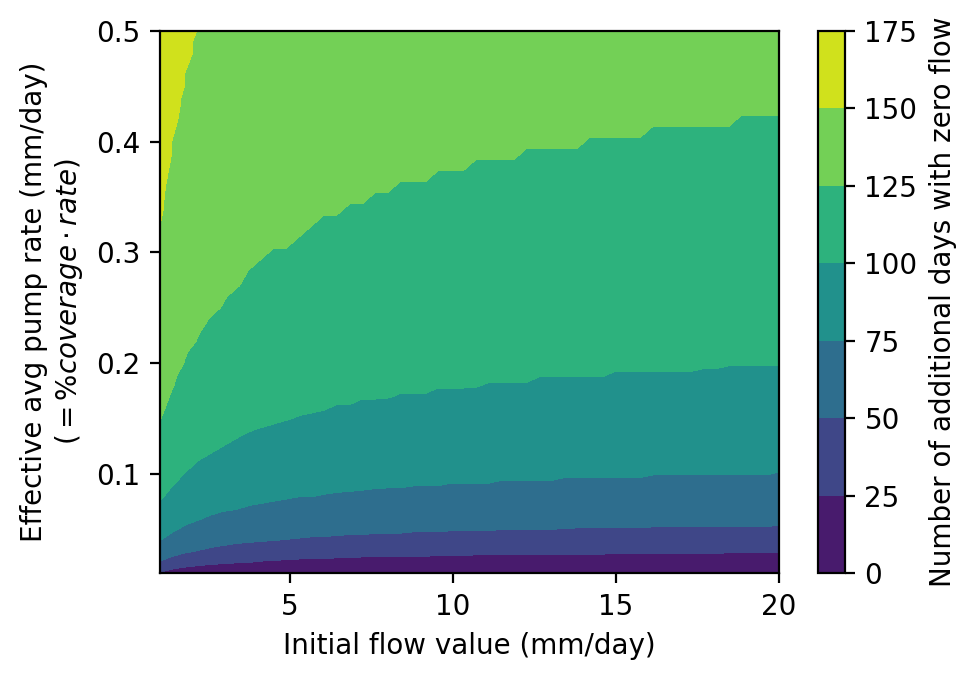

In [ ]:
f,ax = plt.subplots(figsize=(5,3.5))
z = np.reshape(Z_drysoon,shp)
q0s = np.reshape(Q0S,shp)
ws = np.reshape(WS,shp)
m = ax.contourf(q0s,ws,z)
ax.set_ylabel('Effective avg pump rate (mm/day)\n' + r'($=\%coverage\cdot rate)$')
ax.set_xlabel('Initial flow value (mm/day)')
cb = f.colorbar(m)
cb.set_label('Number of additional days with zero flow',fontsize=10)
# ax.set_yscale('symlog')
f.tight_layout()

In [ ]:
data = {
    'summer_decline_percent':[],
    # 'september_decline_percent':[],
    # 'days_sooner_dry':[],
    'creek':[],
    'year':[],
    'use_percentile':[],
    'cover_fraction':[]
    }
dfs = []
keys = list(use_dfs)
for key in keys:
  temp = use_dfs[key].copy()
  data['summer_decline_percent'].append(100*(1-temp['impaired'].sum()/temp['runoff'].sum()))
  data['creek'].append(key[2])
  data['year'].append(key[3])
  data['use_percentile'].append(key[0])
  data['cover_fraction'].append(key[1])


NameError: name 'use_dfs' is not defined

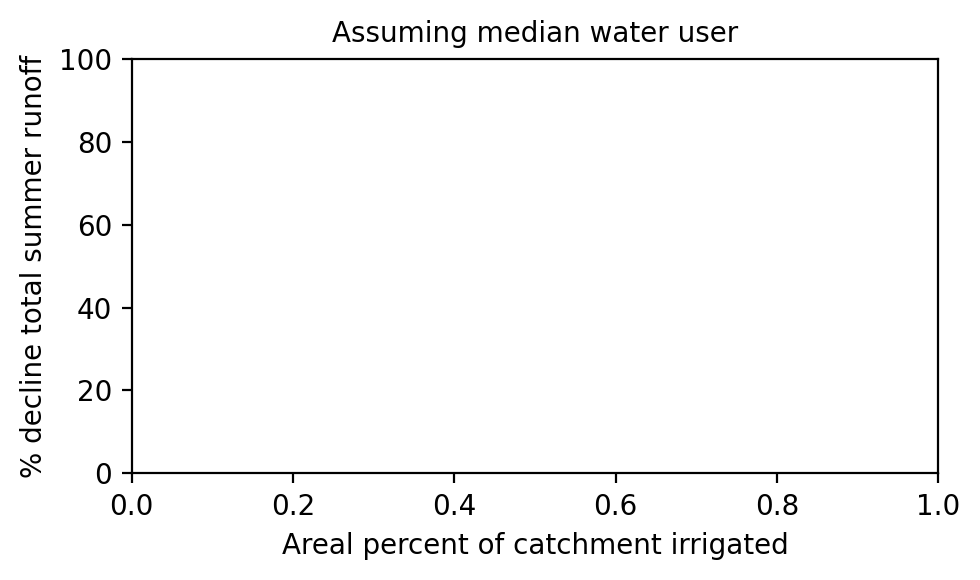

In [ ]:
results = pd.DataFrame.from_dict(data)
results['Catchment'] = results['creek'].map(gageNumsToNames)
# across all years
# median water user
f,ax = plt.subplots(1,figsize=(5,3))
sns.pointplot(x='cover_fraction',y='summer_decline_percent',hue='Catchment',ax=ax,data=results.loc[results.use_percentile==0.5])
ax.set_ylabel('% decline total summer runoff')
ax.set_xlabel('Areal percent of catchment irrigated')
ax.set_title('Assuming median water user',fontsize=10)
ax.set_ylim(0,100)
f.tight_layout()
f.savefig('./summerQdecline.pdf')

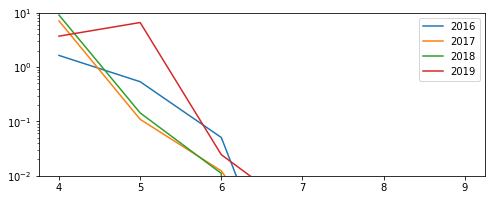

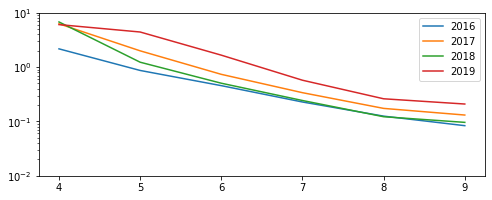

In [ ]:
url = 'https://raw.githubusercontent.com/daviddralle/daviddralle.github.io/master/phil_data_cannabis.csv'
phil = pd.read_csv(url,index_col=0)
months = phil.month.values
years = phil.year.values
dates = pd.to_datetime([str(years[i]) + '-' + str(months[i]) for i in range(len(months))])
phil['datetime'] = dates
for g1 in phil.groupby('creek'):
  f,ax = plt.subplots(1,figsize=(8,3))
  creek = g1[0]
  temp1 = g1[1]
  temp1 = temp1.loc[temp1['farm_use_percentile']==0.5]
  temp1 = temp1.set_index('datetime').sort_index()
  temp1 = temp1.loc[temp1.index.month.isin([4,5,6,7,8,9])]
  temp1['year'] = temp1.index.year
  for g2 in temp1.groupby('year'):
    year = g2[0]
    temp2 = g2[1]
    ax.plot(temp2.index.month, temp2.mean_daily_q_mm_day,label=year)
  ax.legend()
  ax.set_yscale('log')
  ax.set_ylim(1e-2,1e1)


In [ ]:
def fracQ(q,a,b,w):
  return a*q**(b-2)*w

def gQ(q,a,b):
  return a*q**(b-1)

f,ax = plt.subplots(1)
W = np.linspace(0.01,1,10)
q0 = 0.5
for w in W:

  qnatural = [q0]
  qimp = [q0]

  t = np.linspace(0,120,1000)
  dt = t[1]-t[0]
  for i in range(len(t)):
    a = 0.104310
    b = 1.802479
    dQ = -gQ(qnatural[i],a,b)*qnatural[i]*dt
    qnatural.append(qnatural[i]+dQ)

    dQ = -gQ(qimp[i],a,b)*(qimp[i]+w)*dt
    if dQ>qimp[i]:
      qimp.append(0)
    else:
      qimp.append(qimp[i]+dQ)

  qimp = np.array(qimp[1:])
  qnatural = np.array(qnatural[1:])

  # ax.plot(t,qnatural[1:])
  # ax.plot(t,qimp[1:])
  ax.plot(t,qimp/qnatural,label=str(w))
f.legend()

NameError: name 'plt' is not defined

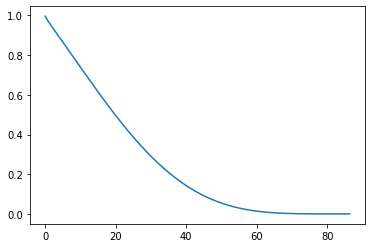

In [ ]:

# ax.set_yscale('log')

In [ ]:
def fracQ(q,a,b,w):
  return a*q**(b-2)*w

w = np.linspace(0,10)
q = np.logspace(np.log10(0.01),np.log10(10))
X,Y = np.meshgrid(w,q)
f,axs = plt.subplots(1,len(params_data),sharey=True,figsize=(14,2.5))
axs[0].set_ylabel('Q (mm/day)')
for i,row in params_data.iterrows():
  ax = axs[i]
  Z = fracQ(Y,row.medA, row.medB, X)
  Z[Z>1] = 1
  mappable =  ax.contourf(X,Y,Z*100,levels=np.arange(0,100,5))
  ax.set_title(gageNumsToNames[row.gage])
  c = f.colorbar(mappable, ax=ax)
  ax.set_yscale('log')
  ax.set_xlabel('W (mm)')
c.set_label('Percent decrease in Q')
# f.text(0.5,0.0, 'Groundwater withdrawal (mm)', ha="center", va="center")
f.tight_layout()

NameError: name 'np' is not defined

# old code

In [ ]:
fit_by_summer = True

from scipy.integrate import odeint
from scipy.interpolate import interp1d as interp1d

url = 'https://raw.githubusercontent.com/daviddralle/daviddralle.github.io/master/phil_data_cannabis.csv'
phil = pd.read_csv(url,index_col=0)
months = phil.month.values
years = phil.year.values
dates = pd.to_datetime([str(years[i]) + '-' + str(months[i]) for i in range(len(months))])
phil['datetime'] = dates
use_percentiles = [0.5 , 0.75, 0.9 , 0.95]
covers = [0.25, 1, 2.5, 4.5]

mapper = {'Dry Creek':'Dry Creek', 'Elder':'Elder Creek'}
phil['catchment'] = phil.creek.map(mapper)

use_dfs = {}
for u in use_percentiles:
  for c in covers:
    for g in ['00000000','11475560']:
      name = gageNumsToNames[g]
      tempdf = phil.loc[phil.farm_use_percentile==u]
      tempdf = tempdf.loc[tempdf.catchment==name]
      col = 'pred_monthly_use%scover'%str(c)
      tempdf = tempdf[[col,'datetime']]
      tempdf = tempdf.set_index('datetime').sort_index()
      tempdf = tempdf.reindex(flow.index)
      tempdf = tempdf.interpolate()
      tempdf = tempdf.loc[tempdf.index.month.isin([5,6,7,8,9])]
      tempdf['year'] = tempdf.index.year
      tempdf['runoff'] = flow[g].loc[tempdf.index]
      for g2 in tempdf.groupby('year'):
        year = g2[0]
        temp = g2[1]
        date_q0 = temp.index.values[temp.runoff.argmax()]
        date_end = temp.index.values[-1]
        q0 = temp.runoff.max()
        qs = temp.runoff.loc[date_q0:].values
        dqs = np.gradient(qs)
        idx = (dqs<0)&(qs>0)
        qs = qs[idx]
        dqs = dqs[idx]
        p = np.polyfit(x=np.log(qs), y=np.log(-dqs), deg=2)
        p[1] = p[1] - 1
        if not fit_by_summer:
          p = ps[g]

        # Use p and initial q0 to solve for flow recession
        vals = temp.runoff.loc[date_q0:].values
        q = temp.runoff.loc[date_q0:]
        days = (q.index[-1]-q.index[0]).days
        dt = 1.0
        t = np.linspace(0,days,len(q))
        w = temp[col].loc[date_q0:].values
        forcing = interp1d(range(len(w)),w,fill_value="extrapolate")

        def fun(q,t):
          return -gQ(q,p)*q
        natQ = odeint(fun, q0, t).flatten()
        natQ[0] = q0

        def fun(q,time):
          return -gQ(q,p)*(q + forcing(time))
        impQ = odeint(fun, q0, t).flatten()
        impQ[0] = q0

        to_save = temp[date_q0:].copy()
        to_save['runoff'] = np.nan
        to_save.loc[date_q0:,'natQ'] = natQ
        to_save.loc[date_q0:,'impQ'] = impQ
        to_save.loc[date_q0:,'frac'] = impQ/natQ
        to_save.loc[date_q0:,'runoff'] = temp.runoff.loc[date_q0:]
        to_save.loc[date_q0:,'impaired'] = impQ/natQ*temp.runoff.loc[date_q0:].values
        use_dfs[(u,c,g,year)] = to_save.copy()


NameError: name 'pd' is not defined